In [26]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import mode

In [7]:
test = pd.read_csv('data//formatted_data//test.csv')
train = pd.read_csv('data//formatted_data//train.csv')

In [8]:
'''
Steps
    1. Hypothesis
    2. Data Exploration     
    3. Data Cleaning
    4. Featuring Engineering
'''

# Data Exploration
#   1. Merging Test and Train
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test], ignore_index=True, sort=False)
print(train.shape, test.shape, data.shape)

#   2. Exploring null values
data.apply(lambda x: sum(x.isnull()))

#   3. Exploring overall data stats
data.describe()

#   4. Exploring unique data in each column (especially useful for categorical columns)
data.apply(lambda x: len(x.unique()))
#     data.dtypes can help show which columns are categorical

#   5. Filter categorical variables (excluding ID cols and source)
cat_cols = [x for x in data.dtypes.index if data.dtypes[x]=='object']
cat_cols = [x for x in cat_cols if x not in ['Item_Identifier','Outlet_Identifier','source']]

#   6. Print frequency of categories
for col in cat_cols:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())

#   7. Exploration Findings/Notes
'''
General Description: there are 1559 items sold at 10 different stores
1. Null Value Columns: [Item_Weight:2439, Outlet_Size: 4016, Item_Outlet_Sales:5681]
2. Stats Description: 
     a. May want to standardize year column in different format other than 1985 to 2009.
     b. Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
3. Category Issues
     a. Item_Fat_Content: ([LF,low fat, Low Fat], [Regular, reg]) *should only be two distinct categories*
     b. Outlet_Type: *May need to combine supermarket types 1,2,3*
     c. Item_Type: Not all categories have substantial numbers. It looks like combining them can give better results.
     
'''

#Data Cleaning

#   8. Null Value Replacement for Item Weight
#     a. Determine the average weight per item
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')
#     b. Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull()
#     c. Impute data and check #missing values before and after imputation to confirm
print('Original #missing: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool, 'Item_Identifier'].apply(lambda x: item_avg_weight.loc[item_avg_weight.index==x,'Item_Weight'][0])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

#   9. Null Value Replacement for Outlet size
#     a. Determine the mode outlet size per outlet type
outlet_size_mode = data[pd.notna(data['Outlet_Size'])==True].pivot_table(values='Outlet_Size', index='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]))
print('Mode for each Outlet_Type:')
print(outlet_size_mode)
#     b. Get a boolean variable specifying missingOutlet_Size values
miss_bool = data['Outlet_Size'].isnull()
#     c. Impute data and check #missing values before and after imputation to confirm
print('\nOriginal #missing: %d'%sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode.loc[outlet_size_mode.index==x,'Outlet_Size'][0])
print('Final #missing: %d'% sum(data['Item_Weight'].isnull()))


#Feature Engineering
#   10. Consider Combining Outlet_Type
#     a. Exploration (keeping outlet type as is because significant difference between different types)
data.pivot_table(values='Item_Outlet_Sales', index='Outlet_Type')

#   11. Modify Item Visibility
#     a. Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')
#     b. Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility']==0)
print('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[visibility_avg.index==x,'Item_Visibility'][0])
print('Number of 0 values after modification: %d'%sum(data['Item_Visibility']==0))
#     c. Creating modifided Item Visibility value that is compared to the mean visibility across all stores
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[visibility_avg.index==x['Item_Identifier'],'Item_Visibility'][0], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

#   12. Create New Column for Item Type (!!!! Should Modify to group better !!!!)
#     a. Get the first two charcters of ID and rename to more intuitive categories
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                            'NC':'Non-Consumable',
                                                            'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

#   13. Creating a new column depicting the years of operation
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

#   14. Modifying Item_Fat Content Categories
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())
print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                            'reg':'Regular',
                                                            'low fat': 'Low Fat'})
#Makes sure that non-consumable items don't have fat content listed
data.loc[data['Item_Type_Combined']=='Non-Consumable','Item_Fat_Content'] = 'Non-Edible'
print(data['Item_Fat_Content'].value_counts())

#   15. One-Hot Encoding Categorical Variables
le = preprocessing.LabelEncoder()
#     a. New vairable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'].values)

#     b. Label Encoding Remaining Categorical Variables
var_mod = ['Item_Fat_Content', 'Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
for i in var_mod:
    data[i] = le.fit_transform(data[i])

#     c. One Hot Coding categorical label encoded columns
data = pd.get_dummies(data,columns=var_mod)

#   16. Convert Data Back into Test and Train sets
#     a. Drops the columns that have been encoded to better formats and are no longer needed
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)
#     b. Divide into test and train:
train = data.loc[data['source']=="train"].copy()
train.drop(['source'],axis=1,inplace=True)
test = data.loc[data['source']=="test"].copy()
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
#     c. Export files as modified versions:
train.to_csv("data/formatted_data/train_modified.csv",index=False)
test.to_csv("data/formatted_data/test_modified.csv",index=False)


(8523, 13) (5681, 12) (14204, 13)

Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Out

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Final #missing: 0
Number of 0 values initially: 879
Number of 0 values after modification: 0
count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64
Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


In [24]:
# Model 1: Mean Based
mean_sales = train['Item_Outlet_Sales'].mean()

#   Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']].copy()
base1['Item_Outlet_Sales'] = mean_sales

rm = ((train['Item_Outlet_Sales']-mean_sales)**2)
rm_val = rm.mean()**(1/2)
print("\nModel Report")
print("RMSE : %.4g"%rm_val)


#   Export submission file
base1.to_csv("alg0.csv",index=False)


Model Report
RMSE : 1706


In [18]:
#Define target and ID columsn
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

def modelfit(alg,dtrain,dtest,predictors,target,IDcol,filename):
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain[target])
    
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    # Perform cross-validation:
    cv_score = model_selection.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))

    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g"%np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g"%(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])

    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({x: dtest[x] for x in IDcol})
    submission.to_csv(filename,index=False)


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 43.44 | Min - 1075 | Max - 1210


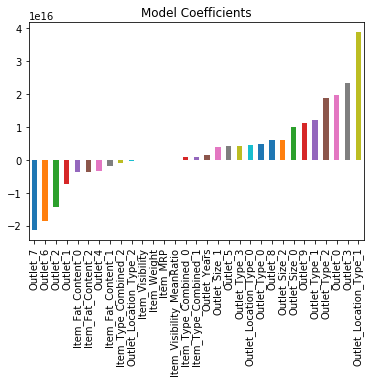

In [19]:
# Model 2: Linear Regression
predictors = [x for x in train.columns if x not in [target]+IDcol]

# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1,train,test,predictors,target,IDcol,'alg1.csv')
coef1 = pd.Series(alg1.coef_,predictors).sort_values()
coef1.plot(kind='bar',title='Model Coefficients')

'''
Large coefficients indicate that this model may be overfitting the dataset. It is a good idea to use Ridge and Lasso regularization methods to mitigate this.
'''


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


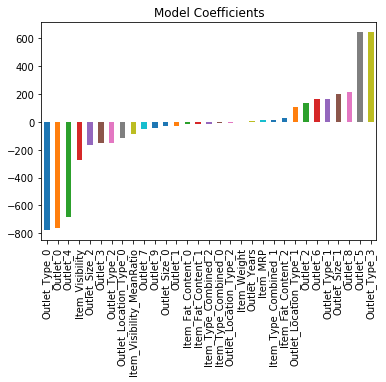

In [25]:
# Model 3: Ridge Regression
predictors = [x for x in train.columns if x not in [target] + IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2,train,test,predictors,target,IDcol,'alg2.csv')
coef2 = pd.Series(alg2.coef_,predictors).sort_values()
coef2.plot(kind='bar',title='Model Coefficients')

In [ ]:
# Model 4: Decision Tree Model
predictors = [x for x in train.columns if x not in [target] + IDcol]
alg3 = DecisionTreeRegressor(max_depth=15,min_samples_leaf=100)
modelfit(alg3,train,test,predictors,target,IDcol,'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_,predictors).sort_values(ass)